In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set(style='white', context='notebook', palette='deep')

Using TensorFlow backend.


In [2]:
#load the data
train = pd.read_csv("/home/sakshi/Documents/mnist/train.csv")
test = pd.read_csv("/home/sakshi/Documents/mnist/test.csv")

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

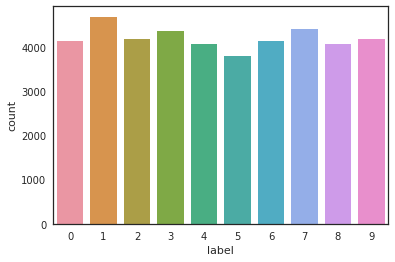

In [3]:
y_train = train['label']
x_train=train.drop(labels=['label'], axis=1)
del train
g=sns.countplot(y_train)
y_train.value_counts()

In [4]:
#check for null
x_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [5]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [6]:
#normalize the data
x_train=x_train/255.0
test=test/255.0

In [7]:
#reshape image in 3 dimensions
x_train=x_train.values.reshape(-1,28,28,1)
test=test.values.reshape(-1,28,28,1)

In [8]:
#one hot vectors
y_train=to_categorical(y_train, num_classes=10)

In [9]:
random_seed = 2

In [10]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=random_seed)

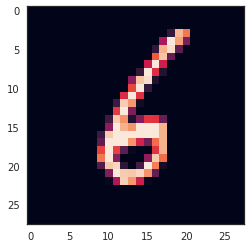

In [11]:
g= plt.imshow(x_train[15][:,:,0])

In [12]:
#set the CNN model
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same',
                activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same',
                activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same',
                activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same',
                activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [13]:
#optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [14]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
#learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                           patience=3, verbose=1,
                                           factor=0.5, min_lr=0.00001)

In [17]:
epochs=5
batch_size=86

In [18]:
datagen = ImageDataGenerator(featurewise_center=False,
                            samplewise_center=False,
                            featurewise_std_normalization=False,
                            samplewise_std_normalization=False,
                            zca_whitening=False,
                            rotation_range=10,
                            zoom_range=0.1,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            horizontal_flip=False,
                            vertical_flip=False)
datagen.fit(x_train)

In [19]:
history = model.fit_generator(datagen.flow(x_train,y_train,batch_size=batch_size),
                             epochs=epochs, validation_data=(x_val,y_val),
                             verbose=2, steps_per_epoch=x_train.shape[0]//batch_size,
                             callbacks=[learning_rate_reduction])

Epoch 1/5
 - 442s - loss: 0.4342 - acc: 0.8580 - val_loss: 0.0562 - val_acc: 0.9817
Epoch 2/5
 - 355s - loss: 0.1343 - acc: 0.9588 - val_loss: 0.0422 - val_acc: 0.9871
Epoch 3/5
 - 353s - loss: 0.1058 - acc: 0.9686 - val_loss: 0.0386 - val_acc: 0.9876
Epoch 4/5
 - 352s - loss: 0.0887 - acc: 0.9733 - val_loss: 0.0299 - val_acc: 0.9905
Epoch 5/5
 - 350s - loss: 0.0787 - acc: 0.9763 - val_loss: 0.0250 - val_acc: 0.9926


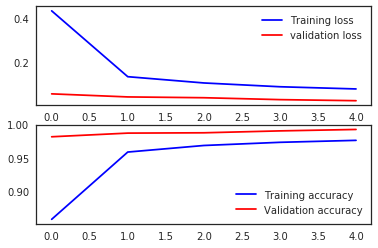

In [20]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label='Training loss')
ax[0].plot(history.history['val_loss'], color='r', label='validation loss', axes=ax[0])
legend=ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label='Training accuracy')
ax[1].plot(history.history['val_acc'], color='r', label='Validation accuracy')
legend=ax[1].legend(loc='best', shadow=True)

In [21]:
results = model.predict(test)
results = np.argmax(results, axis=1)
results=pd.Series(results, name='Label')

In [22]:
submission = pd.concat([pd.Series(range(1,28001), name="ImageId"), results], axis=1)
submission.to_csv("cnn_mnist_2.csv", index=False)